In [1]:
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pylab as plt #for visualization
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from connection import db_string
from sqlalchemy import create_engine
import pmdarima as pm

In [2]:
engine = create_engine(db_string)

In [3]:
#print result of query
china_df = pd.read_sql(
    '''SELECT mid_year, population from countries_populations where country_name = 'China' ''',
    con = engine
)
china_df=china_df.rename(columns={"mid_year":"Year", "population":"Population (Thousands)"})
china_df

,Year,Population (Thousands)
0,1955,610834
1,1956,619598
2,1957,628551
3,1958,637854
4,1959,647556
...,...,...
62,2017,1409517
63,2018,1415046
64,2019,1420062
65,2020,1424548


In [4]:
#print result of query
india_df = pd.read_sql(
    '''SELECT mid_year, population from countries_populations where country_name = 'India' ''',
    con = engine
)
india_df=india_df.rename(columns={"mid_year":"Year", "population":"Population (Thousands)"})
india_df

,Year,Population (Thousands)
0,1955,409269
1,1956,416729
2,1957,424461
3,1958,432482
4,1959,440814
...,...,...
62,2017,1339180
63,2018,1354052
64,2019,1368738
65,2020,1383198


In [5]:
#print result of query
indonesia_df = pd.read_sql(
    '''SELECT mid_year, population from countries_populations where country_name = 'Indonesia' ''',
    con = engine
)
indonesia_df=indonesia_df.rename(columns={"mid_year":"Year", "population":"Population (Thousands)"})
indonesia_df

,Year,Population (Thousands)
0,1955,77328
1,1956,79227
2,1957,81231
3,1958,83332
4,1959,85522
...,...,...
62,2017,263991
63,2018,266795
64,2019,269536
65,2020,272223


In [6]:
#print result of query
america_df = pd.read_sql(
    '''SELECT mid_year, population from countries_populations where country_name = 'United States of America' ''',
    con = engine
)
america_df=america_df.rename(columns={"mid_year":"Year", "population":"Population (Thousands)"})
america_df

,Year,Population (Thousands)
0,1955,171784
1,1956,174806
2,1957,177851
3,1958,180884
4,1959,183878
...,...,...
62,2017,324459
63,2018,326767
64,2019,329093
65,2020,331432


# China

### Data Prepocessing

Not much data prepocessing was necessary for this set of data. The data was retrieved from the SQL database using 'psycopg2' and placed into a Pandas DataFrame. The data was then split into a training set and a test set.

### Feature Engineering
As this was a dataset with only 2 features (time, and population in thousands) those were the two features used. A time-series analysis model was used so both columns, the value and time, were necessary.

In [7]:
china_df.count()

Year                      67
Population (Thousands)    67
dtype: int64

In [8]:
#train test split
#aiming for 85% split (80% left too many in the test data. As the predictions get further out in the time period they get less
#accurate so going up to 85% to limit how many test data points are present)
# 57 train
# 10 test
training_data = china_df[0:57]

test_data = china_df[57:]
test_data

,Year,Population (Thousands)
57,2012,1375199
58,2013,1382793
59,2014,1390110
60,2015,1397029
61,2016,1403500
62,2017,1409517
63,2018,1415046
64,2019,1420062
65,2020,1424548
66,2021,1428481


### Training/Testing Split
The dataset used had 32 rows. A train/test ratio of ~80/20 was used as that ratio is usually regarded as a generally good starting split. In this case, the last 7 entries were used as the testing set.

In [9]:
#EDA

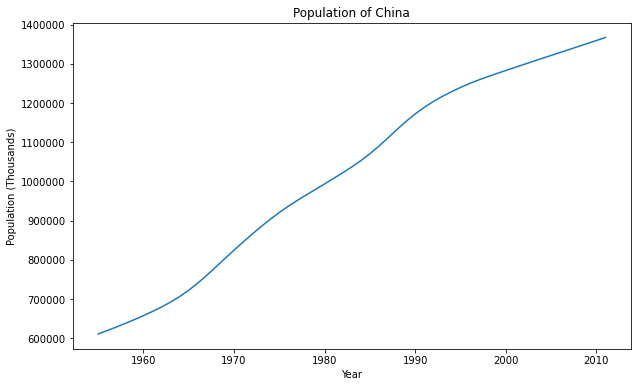

In [10]:
X_training=training_data['Year'].astype('int32')
y_training= training_data['Population (Thousands)'].astype('int32')
plt.plot(X_training,y_training)
plt.xlabel('Year')
plt.ylabel('Population (Thousands)')
plt.title(label='Population of China')
plt.ticklabel_format(style='plain')

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

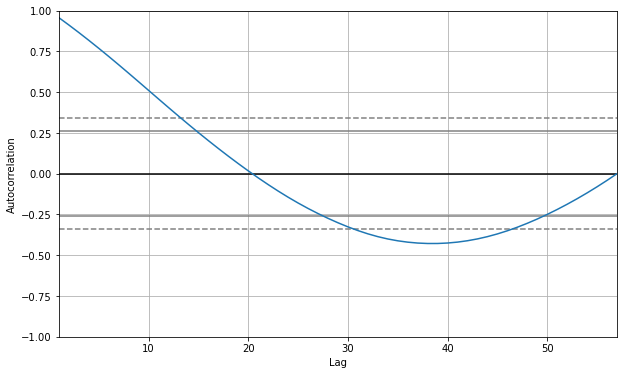

In [11]:
#auto correlation of un altered data. looking to see if it needs to be differenced
autocorrelation_plot(y_training)
#stays positive for about 9 lags
#probably needs to be differenced at least once

In [12]:
# checking stationarity with Augmented Dickey Fuller Test (adfuller)
result = adfuller(y_training)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.426225
p-value: 0.569641


In [13]:
#null value in this test is that the series is non-stationary
# p-value is large so we can't reject null hypothesis
# therefore series is non-stationary and needs to be differenced

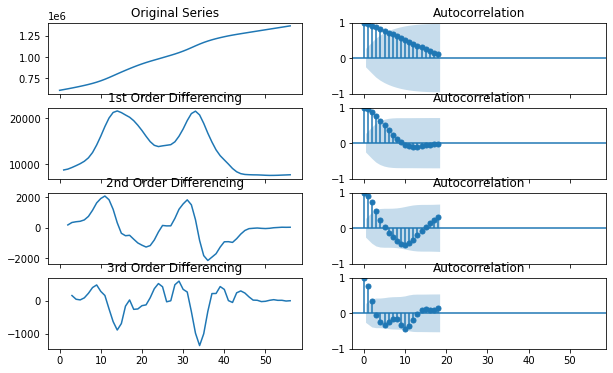

In [14]:
#exploring differencing
# Original Series

fig, axes = plt.subplots(4, 2, sharex=True)
axes[0, 0].plot(y_training); axes[0, 0].set_title('Original Series')
plot_acf(y_training, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(y_training.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(y_training.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(y_training.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(y_training.diff().diff().dropna(), ax=axes[2, 1])

# 3rd Differencing
axes[3, 0].plot(y_training.diff().diff().diff()); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(y_training.diff().diff().diff().dropna(), ax=axes[3, 1])

plt.show()

In [15]:
# doesn't reach stationarity but 
# the 3rd order differencing has the autocorrelation reach 0 the fastest (around 2-3 lags) any higher order would 
# most likely make it dip into the negatives too quickly
# so try d at 3

C:\Users\djkri\anaconda3\envs\mlenv\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


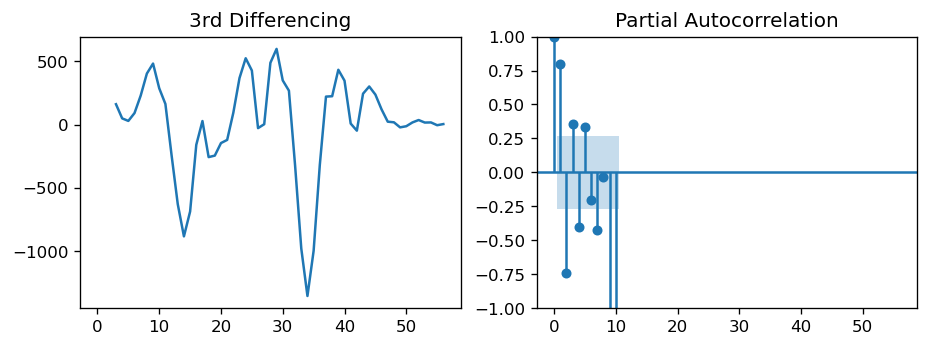

In [16]:
#partial auto correlation to find p term
# PACF plot of 3rd differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(y_training.diff().diff().diff()); axes[0].set_title('3rd Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(y_training.diff().diff().diff().dropna(), ax=axes[1], lags = 10)

plt.show()

In [17]:
# value at first lag is significant (outside of the blue boxed region)
# significant at lag 2 as well but will set p at 1 for now

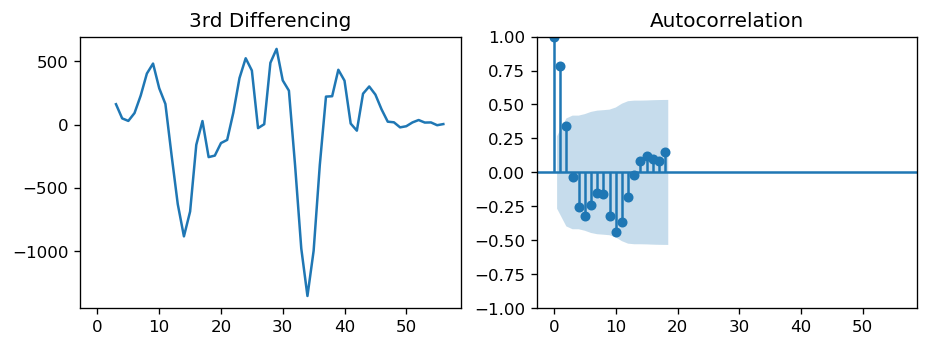

In [18]:
#auto correlation for differenced series to find q value
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(y_training.diff().diff().diff()); axes[0].set_title('3rd Differencing')
axes[1].set(ylim=(0,5))
plot_acf(y_training.diff().diff().diff().dropna(), ax=axes[1])

plt.show()

In [19]:
#similar to pacf
# 1 and 2 are signifcant
# will start with 1 but 2 could also work

In [20]:
#orders for arima model 
#(p,d,q)
# (1,3,1)

### Model Choice and Pros/Cons
The model chosen was an ARIMA (auto-regressive integrated moving average) model. ARIMA is a popularly used model for time-series forecasting. Advantages of this model include; it is a recursive forecasting method (as opposed to a direct method) meaning the model can be used to forecast different time-steps by using the previous prediction as the input for the next prediction and its extendability (able to extend how far into the future the predictions are, this is due to its recursiveness). Meanwhile, the disadvantages of this model are; its poorer performance over longer periods of time and that it has difficulty predicting turning points. The ARIMA model can also be more difficult, for those who are not highly experienced with the model, to adjust and optimize than other time-series forecasting models such as a neural network.

In [21]:
#arima model
#this auto_arima function will test a variety of models with different values for p, q, and d
#it will determine the 'best' model by choosing the one with the lowest AIC
model = pm.auto_arima(y_training, start_p=0, start_q=0, information_criterion= 'aic',
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=3,           # set to 3 as it was chosen from the diagrams
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=801.468, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=802.937, Time=0.03 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=802.940, Time=0.02 sec
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=805.373, Time=0.10 sec
 ARIMA(0,3,0)(0,0,0)[0] intercept   : AIC=803.465, Time=0.00 sec

Best model:  ARIMA(0,3,0)(0,0,0)[0]          
Total fit time: 0.168 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   57
Model:               SARIMAX(0, 3, 0)   Log Likelihood                -399.734
Date:                Thu, 28 Jul 2022   AIC                            801.468
Time:                        12:27:12   BIC                            803.457
Sample:                             0   HQIC                           802.235
                                 - 57                                         
Co

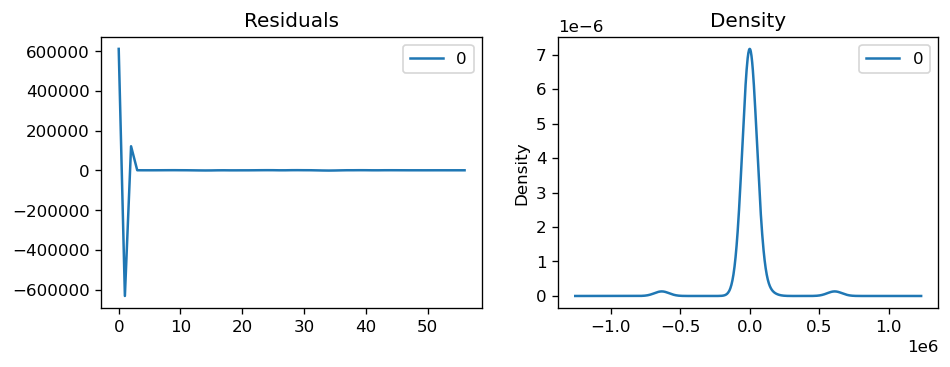

In [22]:
residuals = pd.DataFrame(model.resid())
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [23]:
#making predictions
y_pred = pd.Series(model.predict(10))
y_pred

0    1375243.0
1    1383044.0
2    1390883.0
3    1398760.0
4    1406675.0
5    1414628.0
6    1422619.0
7    1430648.0
8    1438715.0
9    1446820.0
dtype: float64

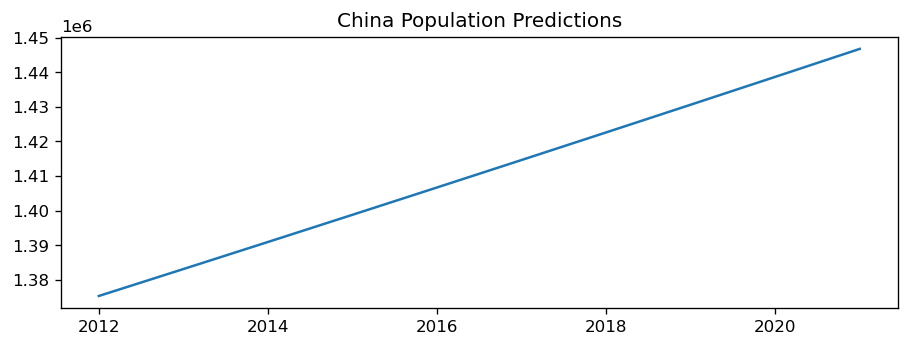

In [24]:
#rename forecast index to correct years
y_pred= y_pred.rename({0:2012, 1:2013, 2:2014, 3:2015, 4:2016, 5:2017, 6:2018, 7:2019, 8:2020,
                      9:2021})
y_pred.plot()
plt.title('China Population Predictions')
plt.show()


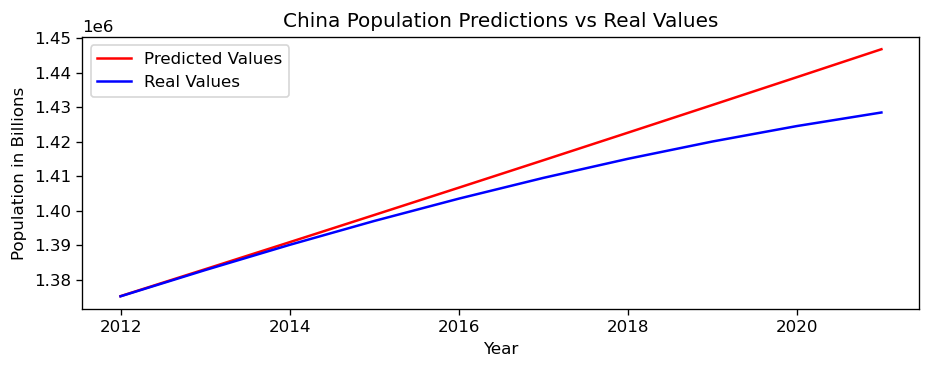

In [25]:
#now plot the model predictions and the test data
y_real = test_data['Population (Thousands)'].astype('int32')
y_real= y_real.rename({57:2012, 58:2013, 59:2014, 60:2015, 61:2016,
                      62:2017, 63:2018, 64:2019, 65:2020, 66:2021})
y_pred.plot(color='red', label = "Predicted Values")
y_real.plot(color='blue', label = "Real Values")
plt.xlabel("Year")
plt.ylabel('Population in Billions')
plt.title('China Population Predictions vs Real Values')
plt.legend()
plt.show()

In [26]:
#This is as good as we can likely get. The rate of increase for china's population starts to decrease around 2015. Since
# the historical data does not show this trend the model will not be able to predict it

In [27]:
# prediction analysis
#mean absolute percent error
mape = np.mean(np.abs(y_pred-y_real)/np.abs(y_real))

#mean absolute scaled error
n = training_data.shape[0]
d = np.abs(np.diff(y_training)).sum()/(n-1)
errors = np.abs(y_real - y_pred)
mase = errors.mean()/d
print(f"MAPE: {mape}",
     f"\nMASE: {mase}")

MAPE: 0.004348630271075628 
MASE: 0.4570168876857572


In [28]:
#mape and mase are good for time series as they can deal with the scale of a time series forecast better than other 
#methods of accuracy/error calculation

#mase compares the predictions of the model to a naive model, meaning a model that uses the last observed value as the value
# for all of the predictions
# a mase of 1 means that the model is just as accurate as picking the last observed value over and over as the prediction
# a mase of 0.5 means that the model is twice as accurate as the naive model


#the mape is a measure of error that is scale independent so it is useful for evaluating error of time series forecasting
#the mape is represented as a percentage
# so our mape of 0.04% should be considered a relatively good error.

In [29]:
#forecasting out past 2021
#will use full dataset for the model to get more accurate forecast
#arima model
model = pm.auto_arima(china_df['Population (Thousands)'], start_p=0, start_q=0, information_criterion= 'aic',
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=3,           # set to 3 as it was chosen from the diagrams
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=939.086, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=940.392, Time=0.03 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=940.397, Time=0.03 sec
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,3,0)(0,0,0)[0] intercept   : AIC=941.021, Time=0.00 sec

Best model:  ARIMA(0,3,0)(0,0,0)[0]          
Total fit time: 0.134 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   67
Model:               SARIMAX(0, 3, 0)   Log Likelihood                -468.543
Date:                Thu, 28 Jul 2022   AIC                            939.086
Time:                        12:27:13   BIC                            941.245
Sample:                             0   HQIC                           939.936
                                 - 67                                         
Covari

In [30]:
#make predictions lets do out to 9 so it ends at 2030, a nice round number
#making predictions
y_pred = pd.Series(model.predict(9))
pd.set_option('display.float_format', lambda x: '%.3f' % x)
y_pred = y_pred.rename({0:2022, 1:2023, 2:2024, 3:2025, 4:2026, 5:2027, 6:2028, 7:2029, 8:2030})
y_pred.to_csv('Predictions/china_predictions.csv')

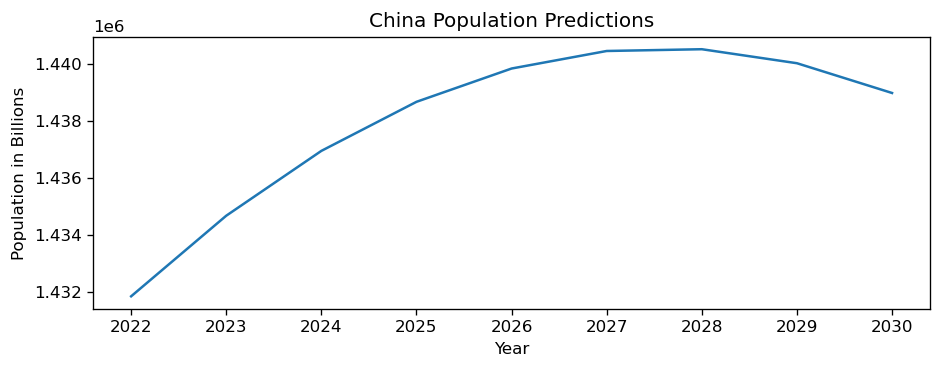

In [31]:
y_pred.plot()
plt.xlabel("Year")
plt.ylabel('Population in Billions')
plt.title('China Population Predictions')
plt.show()

In [32]:
#with the full data set the model is able to start predicting the decrease in population growth

# India

### Data Prepocessing

Not much data prepocessing was necessary for this set of data. The data was retrieved from the SQL database using 'psycopg2' and placed into a Pandas DataFrame. The data was then split into a training set and a test set.

### Feature Engineering
As this was a dataset with only 2 features (time, and population in thousands) those were the two features used. A time-series analysis model was used so both columns, the value and time, were necessary.

In [33]:
#train test split
#aiming for 85% split (80% left too many in the test data. As the predictions get further out in the time period they get less
#accurate so going up to 85% to limit how many test data points are present)
# 57 train
# 10 test
india_train = india_df[0:57]

india_test = india_df[57:]
india_test

,Year,Population (Thousands)
57,2012,1263066
58,2013,1278562
59,2014,1293859
60,2015,1309054
61,2016,1324171
62,2017,1339180
63,2018,1354052
64,2019,1368738
65,2020,1383198
66,2021,1397423


### EDA

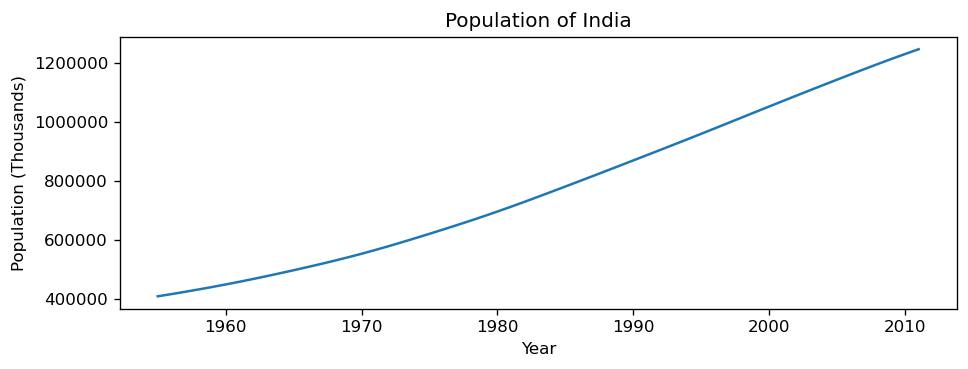

In [34]:
X_training=india_train['Year'].astype('int32')
y_training= india_train['Population (Thousands)'].astype('int32')
plt.plot(X_training,y_training)
plt.xlabel('Year')
plt.ylabel('Population (Thousands)')
plt.title(label='Population of India')
plt.ticklabel_format(style='plain')

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

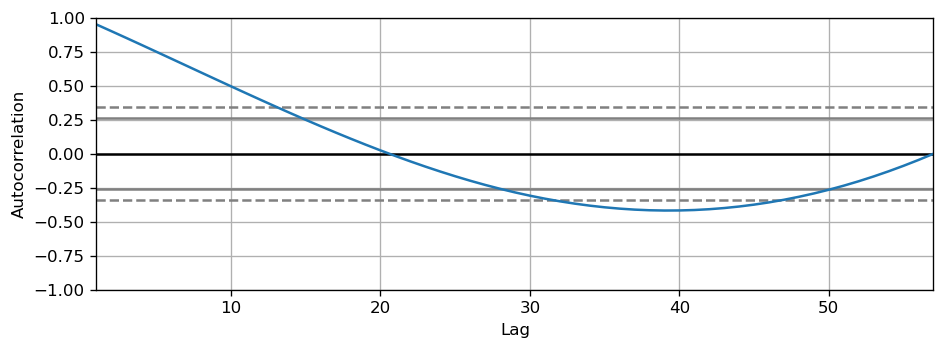

In [35]:
#auto correlation of un altered data. looking to see if it needs to be differenced
autocorrelation_plot(y_training)
#stays positive for about 9 lags
#probably needs to be differenced at least once

In [36]:
# checking stationarity with Augmented Dickey Fuller Test (adfuller)
result = adfuller(y_training)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.272180
p-value: 0.181098


In [37]:
#null value in this test is that the series is non-stationary
# p-value is large so we can't reject null hypothesis
# therefore series is non-stationary and needs to be differenced

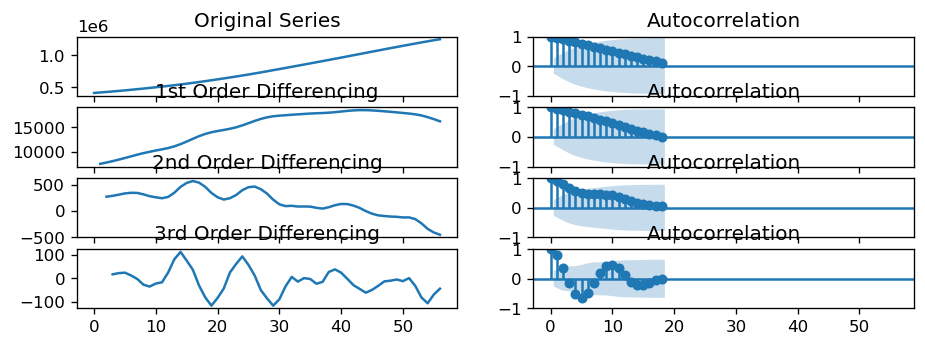

In [38]:
#exploring differencing
# Original Series

fig, axes = plt.subplots(4, 2, sharex=True)
axes[0, 0].plot(y_training); axes[0, 0].set_title('Original Series')
plot_acf(y_training, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(y_training.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(y_training.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(y_training.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(y_training.diff().diff().dropna(), ax=axes[2, 1])

# 3rd Differencing
axes[3, 0].plot(y_training.diff().diff().diff()); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(y_training.diff().diff().diff().dropna(), ax=axes[3, 1])

plt.show()

In [39]:
# doesn't reach stationarity but 
# the 3rd order differencing has the autocorrelation reach 0 the fastest (around 2-3 lags) any higher order would 
# most likely make it dip into the negatives too quickly
# so try d at 3

C:\Users\djkri\anaconda3\envs\mlenv\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


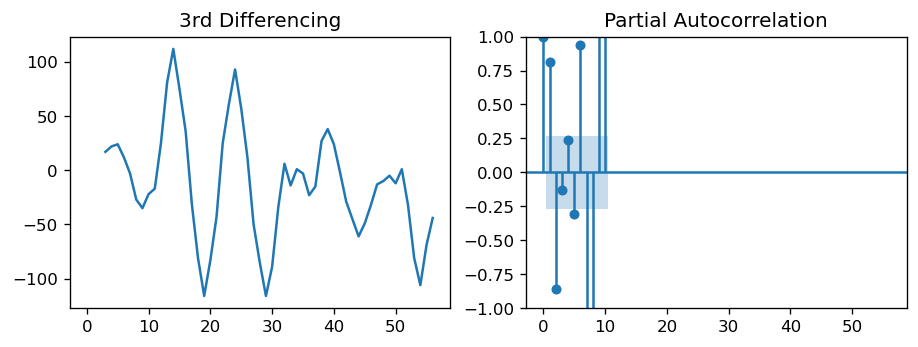

In [40]:
#partial auto correlation to find p term
# PACF plot of 3rd differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(y_training.diff().diff().diff()); axes[0].set_title('3rd Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(y_training.diff().diff().diff().dropna(), ax=axes[1], lags = 10)

plt.show()

In [41]:
# value at first lag is significant (outside of the blue boxed region)
# significant at lag 2 as well. so ideal p might be either 1 or 2

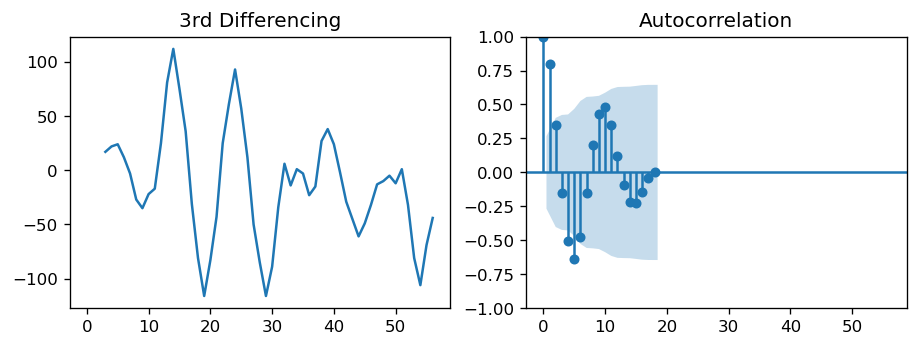

In [42]:
#auto correlation for differenced series to find q value
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(y_training.diff().diff().diff()); axes[0].set_title('3rd Differencing')
axes[1].set(ylim=(0,5))
plot_acf(y_training.diff().diff().diff().dropna(), ax=axes[1])

plt.show()

In [43]:
#similar to pacf
# 1 and 2 are signifcant

### Model Choice and Pros/Cons
The model chosen was an ARIMA (auto-regressive integrated moving average) model. ARIMA is a popularly used model for time-series forecasting. Advantages of this model include; it is a recursive forecasting method (as opposed to a direct method) meaning the model can be used to forecast different time-steps by using the previous prediction as the input for the next prediction and its extendability (able to extend how far into the future the predictions are, this is due to its recursiveness). Meanwhile, the disadvantages of this model are; its poorer performance over longer periods of time and that it has difficulty predicting turning points. The ARIMA model can also be more difficult, for those who are not highly experienced with the model, to adjust and optimize than other time-series forecasting models such as a neural network.

In [44]:
#arima model
#this auto_arima function will test a variety of models with different values for p, q, and d
#it will determine the 'best' model by choosing the one with the lowest AIC
model = pm.auto_arima(y_training, start_p=0, start_q=0, information_criterion= 'aic',
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=3,           # set to 3 as it was chosen from the diagrams
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=583.058, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=574.477, Time=0.02 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=577.508, Time=0.03 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=570.361, Time=0.03 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=562.692, Time=0.04 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=563.645, Time=0.06 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=563.659, Time=0.04 sec
 ARIMA(3,3,0)(0,0,0)[0] intercept   : AIC=550.977, Time=0.07 sec
 ARIMA(2,3,0)(0,0,0)[0] intercept   : AIC=558.875, Time=0.05 sec
 ARIMA(3,3,1)(0,0,0)[0] intercept   : AIC=551.652, Time=0.10 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=551.258, Time=0.08 sec

Best model:  ARIMA(3,3,0)(0,0,0)[0] intercept
Total fit time: 0.538 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   57
Model: 

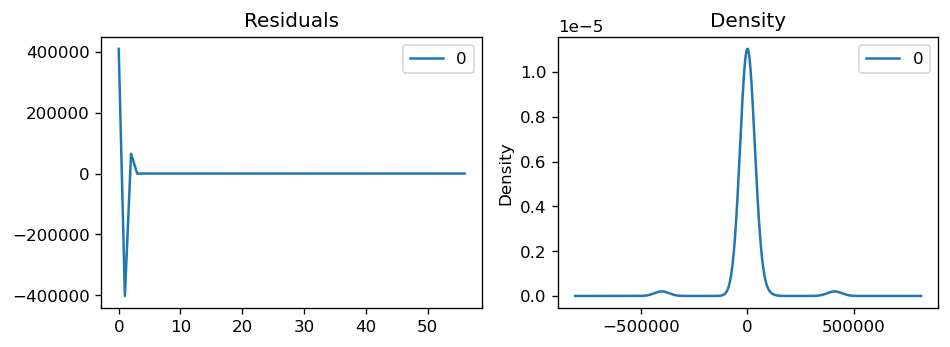

In [45]:
residuals = pd.DataFrame(model.resid())
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [46]:
#making predictions
y_pred = pd.Series(model.predict(10))
y_pred

0   1263025.023
1   1278353.342
2   1293229.912
3   1307656.134
4   1321622.849
5   1335111.691
6   1348099.562
7   1360563.004
8   1372481.124
9   1383836.457
dtype: float64

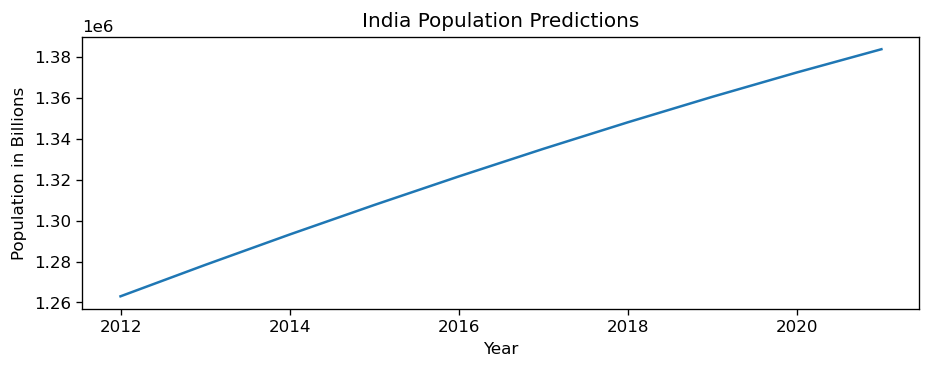

In [47]:
#rename forecast index to correct years
y_pred= y_pred.rename({0:2012, 1:2013, 2:2014, 3:2015, 4:2016, 5:2017, 6:2018, 7:2019, 8:2020,
                      9:2021})
y_pred.plot()
plt.xlabel("Year")
plt.ylabel('Population in Billions')
plt.title('India Population Predictions')
plt.show()

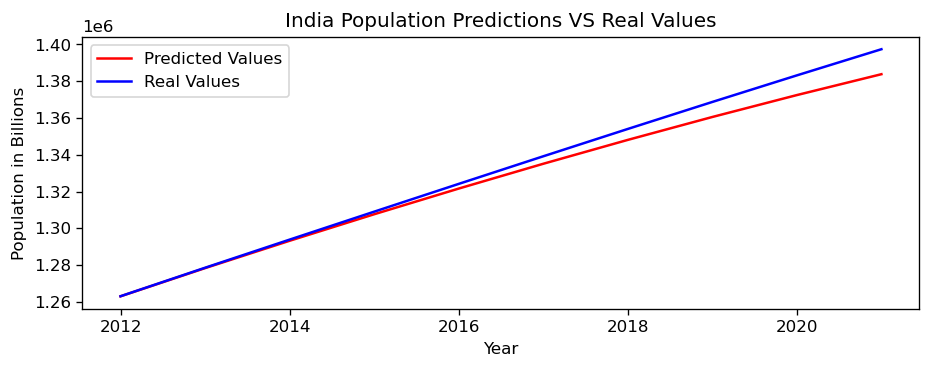

In [48]:
#now plot the model predictions and the test data
y_real = india_test['Population (Thousands)'].astype('int32')
y_real= y_real.rename({57:2012, 58:2013, 59:2014, 60:2015, 61:2016,
                      62:2017, 63:2018, 64:2019, 65:2020, 66:2021})
y_pred.plot(color='red', label = "Predicted Values")
y_real.plot(color='blue', label = "Real Values")
plt.xlabel("Year")
plt.ylabel('Population in Billions')
plt.title("India Population Predictions VS Real Values")
plt.legend()
plt.show()


In [49]:
# prediction analysis
#mean absolute percent error
mape = np.mean(np.abs(y_pred-y_real)/np.abs(y_real))

#mean absolute scaled error
n = training_data.shape[0]
d = np.abs(np.diff(y_training)).sum()/(n-1)
errors = np.abs(y_real - y_pred)
mase = errors.mean()/d
print(f"MAPE: {mape}",
     f"\nMASE: {mase}")

MAPE: 0.0034551080306002282 
MASE: 0.31625809798585974


                                 SARIMAX Results                                  
Dep. Variable:     Population (Thousands)   No. Observations:                   67
Model:                     ARIMA(3, 3, 0)   Log Likelihood                -327.653
Date:                    Thu, 28 Jul 2022   AIC                            663.306
Time:                            12:27:17   BIC                            671.942
Sample:                                 0   HQIC                           666.708
                                     - 67                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7756      0.039     19.857      0.000       0.699       0.852
ar.L2         -0.0151      0.050     -0.300      0.764      -0.114       0.084
ar.L3         -0.309

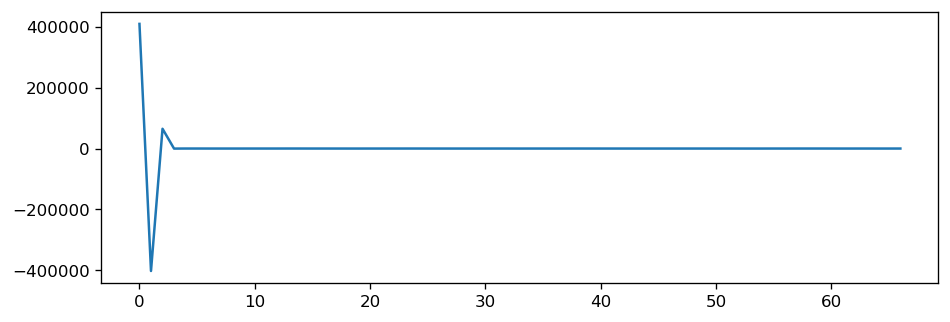

In [50]:
#forecasting out past 2021
#will use full dataset for the model to get more accurate forecast
#arima model
india_fulldata = india_df['Population (Thousands)'].astype('int')
model = ARIMA(india_fulldata, order = (3,3,0))
results_india = model.fit()
print(results_india.summary())
residuals = results_india.resid
residuals.plot()
plt.show()

In [51]:
#make predictions lets do out to 9 to make year end at 2030
y_pred = pd.Series(results_india.forecast(9))
pd.set_option('display.float_format', lambda x: '%.3f' % x)
y_pred = y_pred.rename({67:2022, 68:2023, 69:2024, 70:2025, 71:2026, 72:2027, 73:2028, 74:2029, 75:2030})
y_pred.to_csv('Predictions/india_predictions.csv')

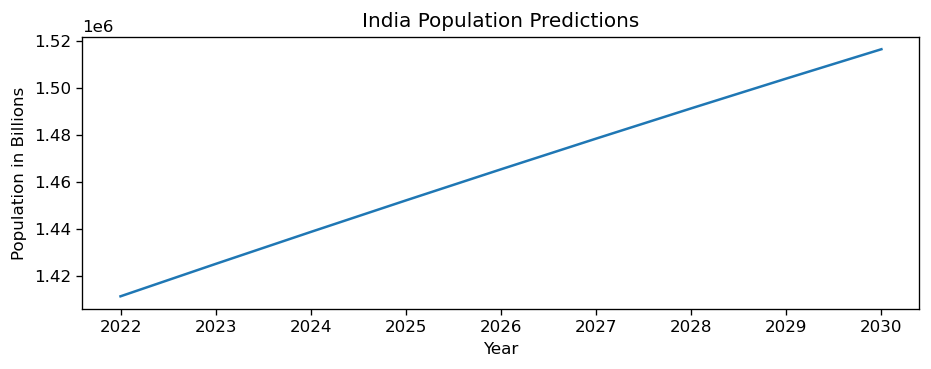

In [52]:
y_pred.plot()
plt.xlabel("Year")
plt.ylabel('Population in Billions')
plt.title('India Population Predictions')
plt.show()

# Indonesia

In [53]:
#train test split
#aiming for 85% split 
#25 train
#7 test
indonesia_train = indonesia_df[0:57]

indonesia_test = indonesia_df[57:]
indonesia_test


,Year,Population (Thousands)
57,2012,248883
58,2013,252032
59,2014,255131
60,2015,258162
61,2016,261115
62,2017,263991
63,2018,266795
64,2019,269536
65,2020,272223
66,2021,274854


### EDA

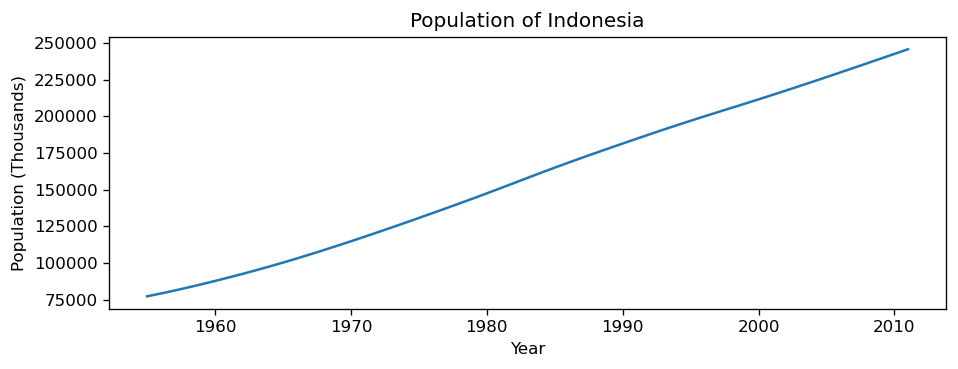

In [54]:
X_training=indonesia_train['Year'].astype('int32')
y_training= indonesia_train['Population (Thousands)'].astype('int32')
plt.plot(X_training,y_training)
plt.xlabel('Year')
plt.ylabel('Population (Thousands)')
plt.title(label='Population of Indonesia')
plt.ticklabel_format(style='plain')

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

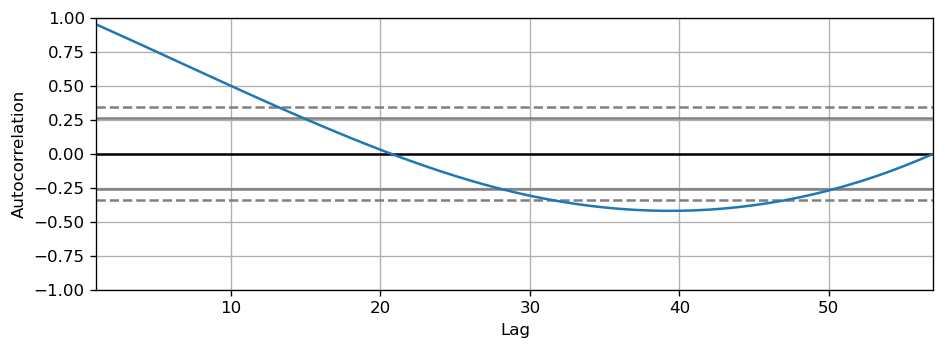

In [55]:
#auto correlation of un altered data. looking to see if it needs to be differenced
autocorrelation_plot(y_training)
#stays positive for about 9 lags
#probably needs to be differenced at least once

In [56]:
# checking stationarity with Augmented Dickey Fuller Test (adfuller)
result = adfuller(y_training)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.305569
p-value: 0.977599


In [57]:
#null value in this test is that the series is non-stationary
# p-value is large so we can't reject null hypothesis
# therefore series is non-stationary and needs to be differenced

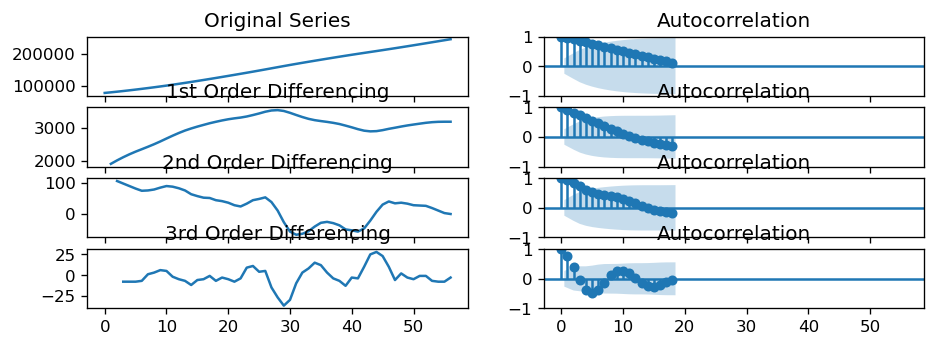

In [58]:
#exploring differencing
# Original Series

fig, axes = plt.subplots(4, 2, sharex=True)
axes[0, 0].plot(y_training); axes[0, 0].set_title('Original Series')
plot_acf(y_training, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(y_training.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(y_training.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(y_training.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(y_training.diff().diff().dropna(), ax=axes[2, 1])

# 3rd Differencing
axes[3, 0].plot(y_training.diff().diff().diff()); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(y_training.diff().diff().diff().dropna(), ax=axes[3, 1])

plt.show()

In [59]:
# doesn't reach stationarity but 
# the 3rd order differencing has the autocorrelation reach 0 the fastest (around 2-3 lags) any higher order would 
# most likely make it dip into the negatives too quickly

C:\Users\djkri\anaconda3\envs\mlenv\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


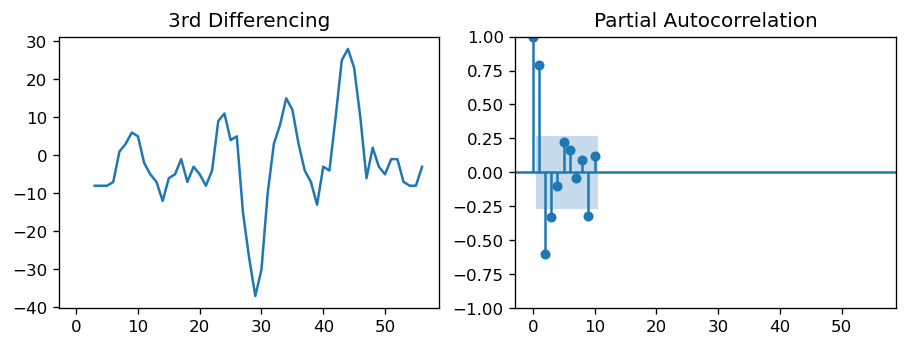

In [60]:
#partial auto correlation to find p term
# PACF plot of 3rd differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(y_training.diff().diff().diff()); axes[0].set_title('3rd Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(y_training.diff().diff().diff().dropna(), ax=axes[1], lags = 10)

plt.show()

In [61]:
# value at first lag is significant (outside of the blue boxed region)
# significant at lag 2 as well. so ideal p might be either 1 or 2

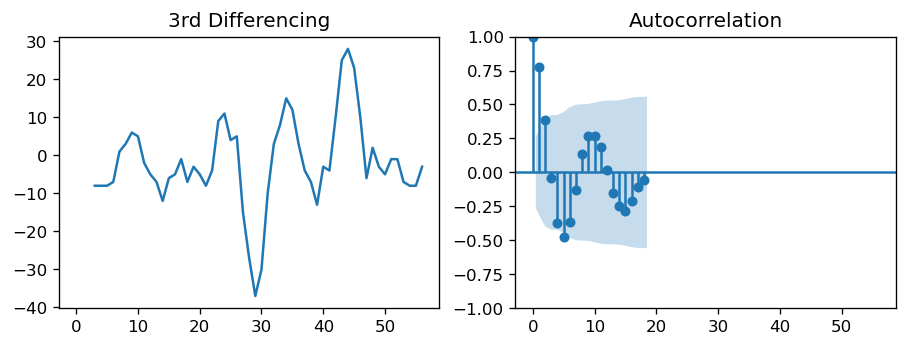

In [62]:
#auto correlation for differenced series to find q value
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(y_training.diff().diff().diff()); axes[0].set_title('3rd Differencing')
axes[1].set(ylim=(0,5))
plot_acf(y_training.diff().diff().diff().dropna(), ax=axes[1])

plt.show()

In [63]:
#similar to pacf
# 1 and 2 are signifcant, could maybe be 3 as it is right at the edge of the line

### Model Choice and Pros/Cons
The model chosen was an ARIMA (auto-regressive integrated moving average) model. ARIMA is a popularly used model for time-series forecasting. Advantages of this model include; it is a recursive forecasting method (as opposed to a direct method) meaning the model can be used to forecast different time-steps by using the previous prediction as the input for the next prediction and its extendability (able to extend how far into the future the predictions are, this is due to its recursiveness). Meanwhile, the disadvantages of this model are; its poorer performance over longer periods of time and that it has difficulty predicting turning points. The ARIMA model can also be more difficult, for those who are not highly experienced with the model, to adjust and optimize than other time-series forecasting models such as a neural network.

In [64]:
#arima model
#this auto_arima function will test a variety of models with different values for p, q, and d
#it will determine the 'best' model by choosing the one with the lowest AIC
model = pm.auto_arima(y_training, start_p=0, start_q=0, information_criterion= 'aic',
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=1,              # frequency of series
                      d=3,           # set at 3 from differencing graphs
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=421.194, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=373.877, Time=0.02 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=383.666, Time=0.02 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=357.538, Time=0.02 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=354.904, Time=0.02 sec
 ARIMA(4,3,0)(0,0,0)[0]             : AIC=356.478, Time=0.02 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=356.719, Time=0.04 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=355.682, Time=0.03 sec
 ARIMA(4,3,1)(0,0,0)[0]             : AIC=358.112, Time=0.05 sec
 ARIMA(3,3,0)(0,0,0)[0] intercept   : AIC=355.835, Time=0.04 sec

Best model:  ARIMA(3,3,0)(0,0,0)[0]          
Total fit time: 0.269 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   57
Model:               SARIMAX(3, 3, 0)   Log Likelihood                -1

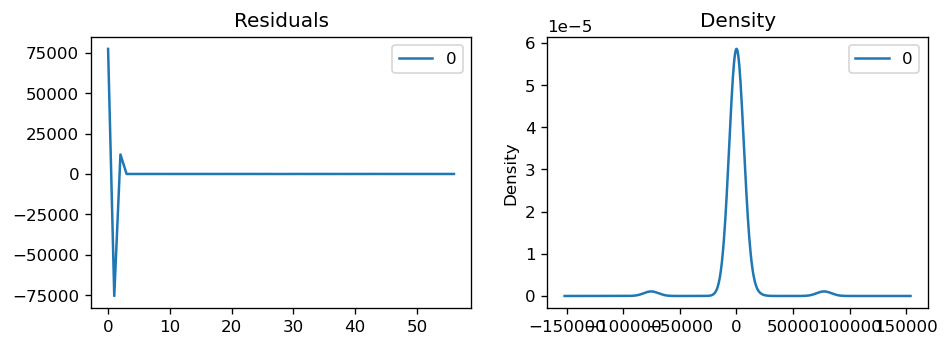

In [65]:
residuals = pd.DataFrame(model.resid())
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [66]:
#making predictions
y_pred = pd.Series(model.predict(10))
y_pred

0   248892.634
1   252081.347
2   255278.403
3   258487.366
4   261710.147
5   264946.858
6   268196.262
7   271456.532
8   274725.989
9   278003.592
dtype: float64

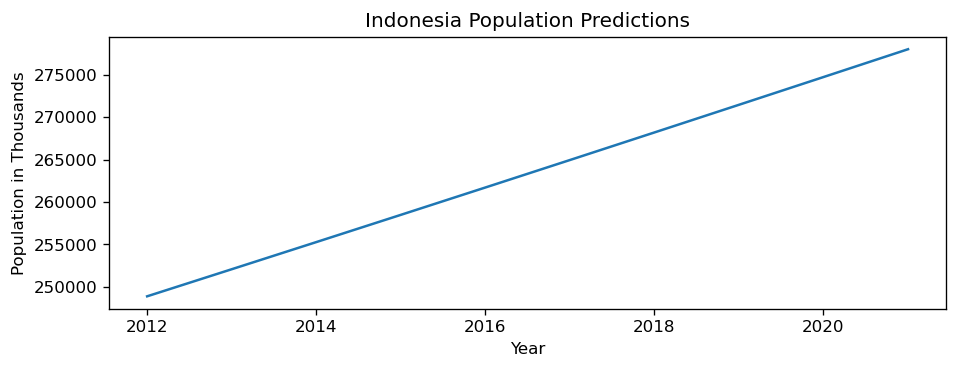

In [67]:
#rename forecast index to correct years
y_pred= y_pred.rename({0:2012, 1:2013, 2:2014, 3:2015, 4:2016, 5:2017, 6:2018, 7:2019, 8:2020,
                      9:2021})
y_pred.plot()
plt.xlabel("Year")
plt.ylabel('Population in Thousands')
plt.title('Indonesia Population Predictions')
plt.show()

In [68]:
#now plot the model predictions and the test data
y_real = indonesia_test['Population (Thousands)'].astype('int32')
y_real= y_real.rename({57:2012, 58:2013, 59:2014, 60:2015, 61:2016,
                      62:2017, 63:2018, 64:2019, 65:2020, 66:2021})
y_pred.plot(color='red', label = "Predicted Values")
y_real.plot(color='blue', label = "Real Values")
plt.xlabel("Year")
plt.ylabel('Population in Billions')
plt.("Indonesia Population Predictions VS Real Values")
plt.legend()
plt.show()

SyntaxError: invalid syntax (282795012.py, line 9)

In [ ]:
# prediction analysis
#mean absolute percent error
mape = np.mean(np.abs(y_pred-y_real)/np.abs(y_real))

#mean absolute scaled error
n = training_data.shape[0]
d = np.abs(np.diff(y_training)).sum()/(n-1)
errors = np.abs(y_real - y_pred)
mase = errors.mean()/d
print(f"MAPE: {mape}",
     f"\nMASE: {mase}")

In [ ]:
#forecasting out past 2021
#will use full dataset for the model to get more accurate forecast
#arima model
indonesia_fulldata = indonesia_df['Population (Thousands)'].astype('int')
model = ARIMA(indonesia_fulldata, order=(3,3,0))
results_indonesia = model.fit()
print(results_indonesia.summary())
residuals = results_indonesia.resid
residuals.plot()
plt.show()

In [ ]:
#make predictions lets do out to 7 again like the test data
#making predictions
y_pred = pd.Series(results_indonesia.forecast(7))
pd.set_option('display.float_format', lambda x: '%.3f' % x)
y_pred = y_pred.rename({67:2022, 68:2023, 69:2024, 70:2025, 71:2026, 72:2027, 73:2028, 74:2029, 75:2030})
y_pred.to_csv('Predictions/indonesia_predictions.csv')

In [ ]:
y_pred.plot()
plt.xlabel("Year")
plt.ylabel('Population in Thousands')
plt.title('Indoneseia Population Predictions')
plt.show()

# USA

In [ ]:
#train test split
#aiming for 85% split 
america_train = america_df[0:57]

america_test = america_df[57:]
america_test


### EDA

In [ ]:
X_training= america_train['Year'].astype('int32')
y_training= america_train['Population (Thousands)'].astype('int32')
plt.plot(X_training,y_training)
plt.xlabel('Year')
plt.ylabel('Population (Thousands)')
plt.title(label='Population of America')
plt.ticklabel_format(style='plain')

In [ ]:
#auto correlation of un altered data. looking to see if it needs to be differenced
autocorrelation_plot(y_training)
#stays positive for about 9 lags
#probably needs to be differenced at least once

In [ ]:
# checking stationarity with Augmented Dickey Fuller Test (adfuller)
result = adfuller(y_training)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [ ]:
#null value in this test is that the series is non-stationary
# p-value is large so we can't reject null hypothesis
# therefore series is non-stationary and needs to be differenced

In [ ]:
#exploring differencing
# Original Series

fig, axes = plt.subplots(4, 2, sharex=True)
axes[0, 0].plot(y_training); axes[0, 0].set_title('Original Series')
plot_acf(y_training, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(y_training.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(y_training.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(y_training.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(y_training.diff().diff().dropna(), ax=axes[2, 1])

# 3rd Differencing
axes[3, 0].plot(y_training.diff().diff().diff()); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(y_training.diff().diff().diff().dropna(), ax=axes[3, 1])

plt.show()

In [ ]:
# 3rd order looks the 'best' go with 3

In [ ]:
#partial auto correlation to find p term
# PACF plot of 2nd differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(y_training.diff().diff().diff()); axes[0].set_title('3rd Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(y_training.diff().diff().diff().dropna(), ax=axes[1], lags = 10)

plt.show()

In [ ]:
# value at first lag is significant (outside of the blue boxed region)
# significant at lag 2 as well. so ideal p might be either 1 or 2

In [ ]:
#auto correlation for differenced series to find q value
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(y_training.diff().diff().diff()); axes[0].set_title('3rd differencing')
axes[1].set(ylim=(0,5))
plot_acf(y_training.diff().diff().diff().dropna(), ax=axes[1])

plt.show()

In [ ]:
#similar to pacf
# 1 and 2 are signifcant

### Model Choice and Pros/Cons
The model chosen was an ARIMA (auto-regressive integrated moving average) model. ARIMA is a popularly used model for time-series forecasting. Advantages of this model include; it is a recursive forecasting method (as opposed to a direct method) meaning the model can be used to forecast different time-steps by using the previous prediction as the input for the next prediction and its extendability (able to extend how far into the future the predictions are, this is due to its recursiveness). Meanwhile, the disadvantages of this model are; its poorer performance over longer periods of time and that it has difficulty predicting turning points. The ARIMA model can also be more difficult, for those who are not highly experienced with the model, to adjust and optimize than other time-series forecasting models such as a neural network.

In [ ]:
#arima model
#this auto_arima function will test a variety of models with different values for p, q, and d
#it will determine the 'best' model by choosing the one with the lowest AIC
model = pm.auto_arima(y_training, start_p=0, start_q=0, information_criterion= 'aic',
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=1,              # frequency of series
                      d=3,           # set at 3 from differencing graphs
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

In [ ]:
# residuals = pd.DataFrame(model.resid())
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
#making predictions
y_pred = pd.Series(model.predict(10))
y_pred

In [ ]:
#rename forecast index to correct years
y_pred= y_pred.rename({0:2012, 1:2013, 2:2014, 3:2015, 4:2016, 5:2017, 6:2018, 7:2019, 8:2020,
                      9:2021})
y_pred.plot()
plt.xlabel("Year")
plt.ylabel('Population in Thousands')
plt.title('USA Population Predictions')
plt.show()

In [ ]:
#now plot the model predictions and the test data
y_real = america_test['Population (Thousands)'].astype('int32')
y_real= y_real.rename({57:2012, 58:2013, 59:2014, 60:2015, 61:2016,
                      62:2017, 63:2018, 64:2019, 65:2020, 66:2021})
y_pred.plot(color='red', label = "Predicted Values")
y_real.plot(color='blue', label = "Real Values")
plt.xlabel("Year")
plt.ylabel('Population in Billions')
plt.legend()
plt.title('USA Population Predictions Vs Real Values')
plt.show()

In [ ]:
# prediction analysis
#mean absolute percent error
mape = np.mean(np.abs(y_pred-y_real)/np.abs(y_real))

#mean absolute scaled error
n = training_data.shape[0]
d = np.abs(np.diff(y_training)).sum()/(n-1)
errors = np.abs(y_real - y_pred)
mase = errors.mean()/d
print(f"MAPE: {mape}",
     f"\nMASE: {mase}")

In [ ]:
#forecasting out past 2021
#will use full dataset for the model to get more accurate forecast
#arima model
america_fulldata = america_df['Population (Thousands)'].astype('int')
model = ARIMA(america_fulldata, order=(3,3,3))
results_america = model.fit()
print(results_america.summary())
residuals = results_america.resid
residuals.plot()
plt.show()

In [ ]:
# make predictions lets do out to 7 again like the test data
#making predictions
y_pred = pd.Series(results_america.forecast(7))
pd.set_option('display.float_format', lambda x: '%.3f' % x)
y_pred = y_pred.rename({67:2022, 68:2023, 69:2024, 70:2025, 71:2026, 72:2027, 73:2028, 74:2029, 75:2030})
y_pred.to_csv('Predictions/america_predictions.csv')

In [ ]:
y_pred.plot()
plt.xlabel("Year")
plt.ylabel('Population in Thousands')
plt.title('USA Population Predictions')
plt.show()
